<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "D1L-PAL"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/D1L-PAL/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


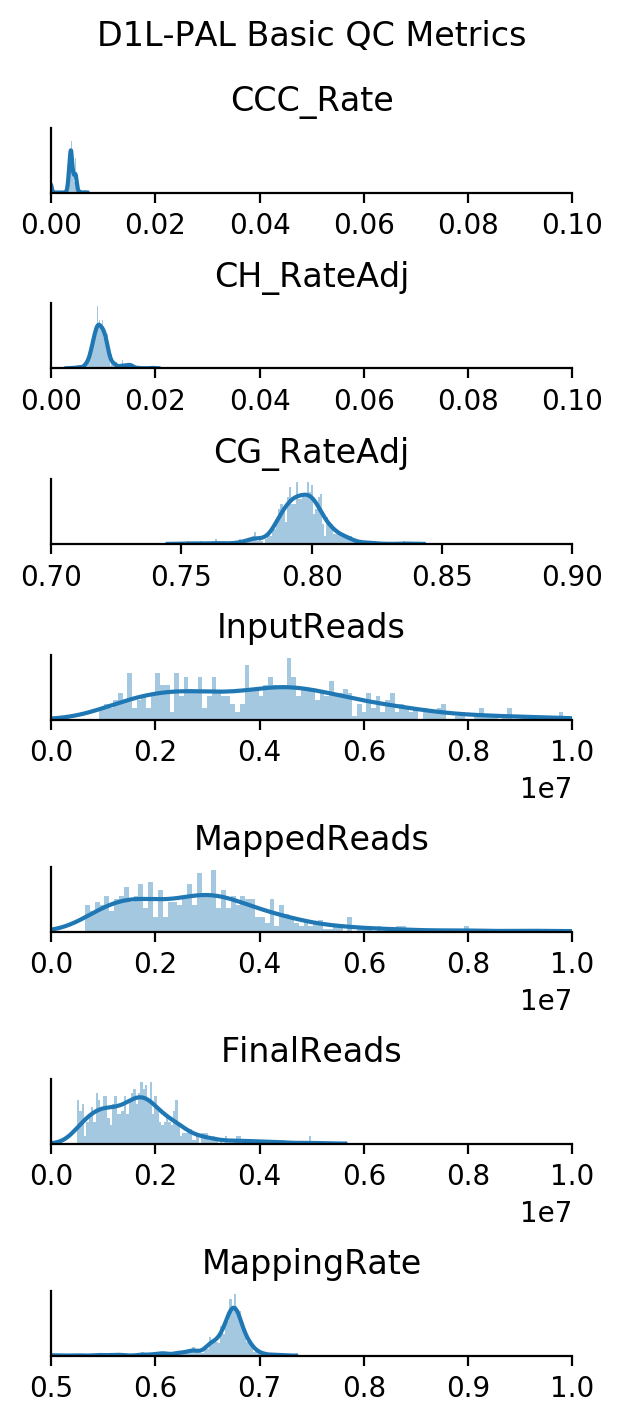

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

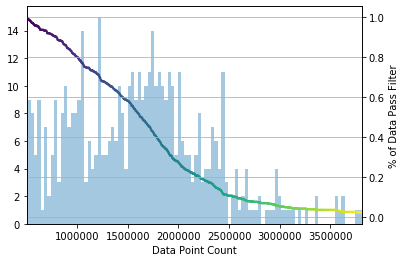

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 495/495 (100.0%)
CG_RateAdj passed 495/495 (100.0%)
CH_RateAdj passed 495/495 (100.0%)
FinalReads passed 495/495 (100.0%)
MappingRate passed 495/495 (100.0%)
Overall passed 495/495 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180109 7
180110 54
180111 34
180220 4
180222 5
180320 4
180329 18
180403 1
180405 1
180724 19
180806 158
180911 125
180917 3
181015 6
181016 26
181204 28
181220 2


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 59 15.4%
ad002 61 15.9%
ad004 50 13.0%
ad006 68 17.7%
ad007 67 17.4%
ad008 71 18.5%
ad010 67 17.4%
ad012 52 13.5%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
2D_M_2123,/gale/raidix/rdx-4/CEMBA_RS1/2D/CEMBA180403_2D...,0.00375,0.807740,0.807020,0.013290,0.009580,2261807.0,5376528,3477723.0,2D,...,18.397718,-8.033674,18.638741,47.651375,D1L-PAL,7.326812,-16.449732,25.353864,-31.687108,True
2E_M_1046,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.00413,0.814070,0.813300,0.011610,0.007510,1056950.0,2759590,1683910.0,2E,...,18.456881,-6.677870,16.303642,46.033810,D1L-PAL,5.691271,-15.633781,27.144389,-28.029863,True
2E_M_1191,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.00414,0.818210,0.817450,0.012280,0.008170,1229332.0,3125234,1950196.0,2E,...,18.575788,-6.721601,16.594669,46.460778,D1L-PAL,6.375481,-15.757970,27.112212,-30.151514,True
2E_M_1391,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.00417,0.815350,0.814580,0.013090,0.008960,1001830.0,2483592,1540062.0,2E,...,18.434839,-6.528199,16.354767,46.066719,D1L-PAL,5.881123,-15.757410,27.060180,-28.271659,True
2E_M_1618,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180222_2E...,0.00465,0.821710,0.820880,0.016700,0.012110,802215.0,2051360,1245403.0,2E,...,18.141539,-6.704711,16.857589,45.982523,D1L-PAL,5.401583,-16.262253,25.376111,-28.503549,True
2E_M_2135,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180222_2E...,0.00481,0.825040,0.824190,0.014610,0.009850,1212474.0,3029882,1895079.0,2E,...,18.448938,-6.858245,16.721389,46.469793,D1L-PAL,5.993075,-15.827495,26.696249,-28.892626,True
2E_M_2161,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180222_2E...,0.00430,0.812410,0.811600,0.012450,0.008190,1038404.0,2496998,1546086.0,2E,...,18.642057,-7.195773,17.081399,46.956954,D1L-PAL,6.819125,-15.740456,27.357804,-33.134298,True
2E_M_2464,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180222_2E...,0.00475,0.813640,0.812750,0.013110,0.008400,622173.0,1496360,907439.0,2E,...,18.387501,-6.548717,16.236437,45.801129,D1L-PAL,5.650253,-15.603008,27.260969,-27.655724,True
2E_M_2521,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180222_2E...,0.00437,0.822280,0.821500,0.012230,0.007890,500829.0,1313134,771570.0,2E,...,18.333445,-6.489803,16.230429,45.769947,D1L-PAL,5.441714,-15.659396,27.157911,-27.272353,True
